In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
from matplotlib import rcParams
from cycler import cycler

# -- Figure size --
rcParams['figure.figsize'] = (12, 4)
# -- Saving Options --
rcParams['savefig.bbox'] = 'tight'
rcParams['savefig.dpi'] = 500
rcParams['savefig.transparent'] = True
# -- Plot Styles --
rcParams['lines.linewidth'] = 0.3
teal = (106 / 256, 197 / 256, 179 / 256)
navy = (56 / 256, 74 / 256, 143 / 256)
pink = [199 / 255, 99 / 255, 150 / 255]
rcParams['axes.prop_cycle'] = cycler(color=[teal, navy, pink])

In [23]:
!pip install transformers

In [27]:
import nltk

In [24]:
import tensorflow as tf

In [25]:
from transformers import AutoTokenizer
from transformers import BertConfig
from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam

In [26]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline

In [7]:
#MODEL = "bert-base-multilingual-uncased" # bert base
#tokenizer = AutoTokenizer.from_pretrained(MODEL)
#model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

In [8]:
data = pd.read_csv('subtaskA_train.csv').drop(columns=['Id'])

In [9]:
data.head()

,comment_text,conspiratorial
0,⚡Se non ci fossero soldati non ci sarebbero gu...,0
1,"21/08/21]( [PRE-PRINT]\n\n📄__ ""Shedding of Inf...",1
2,PAURA E DELIRIO ALLA CNN: IL MINISTERO DELLA V...,1
3,L'Aspirina non aumenta la sopravvivenza dei pa...,0
4,L'Italia non puo' dare armi lo vieta la Costit...,0


In [10]:
data.shape

(1842, 2)

In [11]:
found=0
for e in list(data.columns):
    if data[e].isna().any():
        found+=1
        print(e, data[e].isna().sum())
if found==0:
  print('No NaN values found')


No NaN values found


In [12]:
X_train = data['comment_text']
y_train = data['conspiratorial']

In [13]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)


In [14]:
train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)

In [15]:
val_data

,comment_text,conspiratorial
1558,"Bonomi: produrre è diventato antieconomico, si...",0
1157,"No, la Svizzera non dà “in automatico” aiuti a...",0
352,L'Italia dipende dalle importazioni di grano d...,1
1018,"Ecco, questa è una notizia che mi rattrista \n...",0
1395,Quello che Salvini non dice sui tamponi (non) ...,0
...,...,...
941,Stanno giungendo da Israele verso l'Ucraina de...,1
1223,Tanto a queste merde non gli importa più nient...,1
1269,Beh quando i scherzi sono simpatici.. ok... ...,0
1779,JUST IN - Onu vota sulla sospensione della Rus...,0


In [16]:
model_name = "bert-base-multilingual-uncased" # bert base
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2) # num labels = numero di classi del mio task
tokenizer = AutoTokenizer.from_pretrained(model_name)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
#max_length = 1000
#tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=max_length)
tokenizer

BertTokenizerFast(name_or_path='bert-base-multilingual-uncased', vocab_size=105879, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [18]:
#loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#model.compile(optimizer='adam', loss=loss)

In [19]:
config = BertConfig()
print(config)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.31.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



## NLTK preprocessing

### distribuzione parole

In [20]:
data.head()

,comment_text,conspiratorial
0,⚡Se non ci fossero soldati non ci sarebbero gu...,0
1,"21/08/21]( [PRE-PRINT]\n\n📄__ ""Shedding of Inf...",1
2,PAURA E DELIRIO ALLA CNN: IL MINISTERO DELLA V...,1
3,L'Aspirina non aumenta la sopravvivenza dei pa...,0
4,L'Italia non puo' dare armi lo vieta la Costit...,0


In [28]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [29]:
tokens = list()
idx = 0

for row in data.comment_text:
    tokens_sent = nltk.word_tokenize(row)
    tokens += tokens_sent

print('tokens:', len(tokens),
      '\nvocabulary:', len(set(tokens)),
      '\nTTR:', len(set(tokens))/len(tokens))

tokens: 108992 
vocabulary: 17906 
TTR: 0.16428728714034058


In [31]:
words, freqs = np.unique(tokens, return_counts=True)[0], np.unique(tokens, return_counts=True)[1]

sorted_freqs = sorted(zip(freqs, words), reverse=True)
sorted_frequencies, sorted_words = zip(*sorted_freqs)

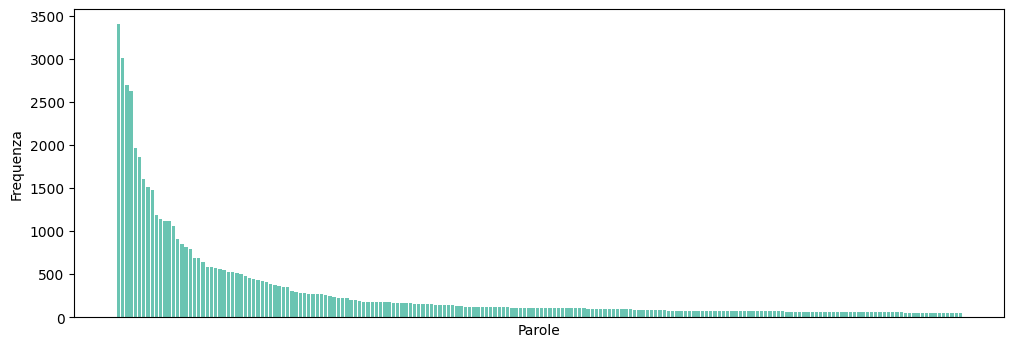

In [32]:
plt.bar(sorted_words[:200], sorted_frequencies[:200])
plt.xlabel('Parole')
plt.ylabel('Frequenza')

plt.xticks([])

#plt.savefig('zipf.pdf', dpi=300, bbox_inches='tight')
plt.show()

### distribuzione POS

In [33]:
punteggiatura = ('.', ',', ':', ';', '?', '!', '--', '-', '(', ')', '``', "''", '#', '$')
aggettivi = ('JJ', 'JJR', 'JJS')
sostantivi = ('NN', 'NNS', 'NNP', 'NNPS')
verbi = ('VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'MD')
avverbi = ('RB', 'RBR', 'RBS', 'WRB')
articoli = ('DT',)
preposizioni = ('IN', 'RP')
congiunzioni = ('CC', 'IN')
pronomi = ('PRP', 'PRPS', 'WP', 'WPS')

In [34]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [35]:
tok_pos = nltk.pos_tag(tokens) #(token, POS)

pos = list() #pos only
for tok, p in tok_pos:
    if p not in punteggiatura:
        pos.append(p)


In [36]:
pos_count= list()
for p, count in zip(np.unique(pos, return_counts=True)[0], np.unique(pos, return_counts=True)[1]):
    pos_count.append((count,p))

sorted(pos_count, reverse=True)[:10]

[(51787, 'NN'),
 (16864, 'NNP'),
 (9822, 'JJ'),
 (4097, 'FW'),
 (3275, 'IN'),
 (1962, 'VBP'),
 (1633, 'VBZ'),
 (1570, 'CD'),
 (1299, 'DT'),
 (1037, 'VBD')]

In [37]:
def mergePOS(pos_lst, pos_counts, pos_dict, pos_key):
    for count, pos in pos_counts:
        if pos in pos_lst:
            pos_dict[pos_key]= pos_dict.get(pos_key) + count

In [38]:
pos_grouped = {
    'aggettivi':0,
    'sostantivi':0,
    'verbi':0,
    'avverbi':0,
    'articoli':0,
    'preposizioni':0,
    'congiunzioni':0
}

mergePOS(aggettivi, pos_count, pos_grouped, 'aggettivi')
mergePOS(sostantivi, pos_count, pos_grouped, 'sostantivi')
mergePOS(verbi, pos_count, pos_grouped, 'avverbi')
mergePOS(avverbi, pos_count, pos_grouped, 'verbi')
mergePOS(articoli, pos_count, pos_grouped, 'articoli')
mergePOS(preposizioni, pos_count, pos_grouped, 'preposizioni')
mergePOS(congiunzioni, pos_count, pos_grouped, 'congiunzioni')

In [39]:
pos_grouped

{'aggettivi': 9834,
 'sostantivi': 69244,
 'verbi': 1049,
 'avverbi': 5349,
 'articoli': 1299,
 'preposizioni': 3288,
 'congiunzioni': 3746}

In [42]:
sorted_pos = {k: v for k, v in sorted(pos_grouped.items(), key=lambda item: item[1], reverse=True)}

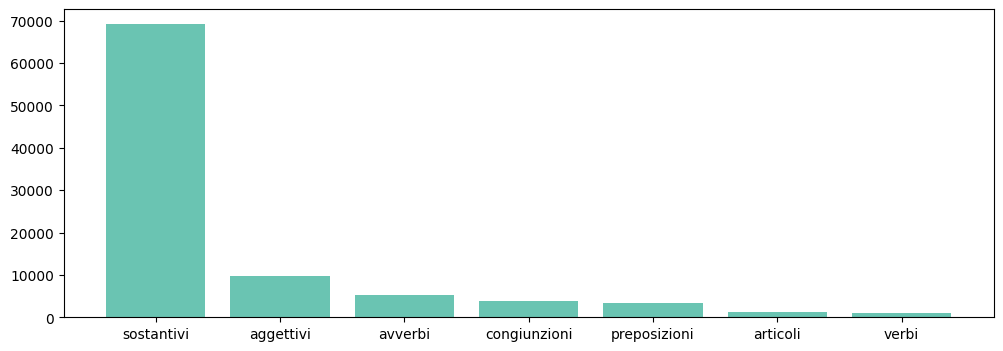

In [43]:
plt.bar(sorted_pos.keys(), sorted_pos.values())

#plt.xticks(rotation=45)
plt.show()

In [40]:
pos_grouped['verbi']/pos_grouped['sostantivi']

0.015149327017503322

### NE

In [46]:
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.


True

In [48]:
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [51]:
def extract_NE(tok_pos, NE):
  NEs = list()
  freq_NEs = list()

  # si ottiene l'albero, quindi si controlla che ci siano nodi intermedi etichettati
  # con una data NE
  ent_nom = nltk.ne_chunk(tok_pos)
  for nodo in ent_nom:
      name_ent = ''
      if hasattr(nodo, 'label'):
          if nodo.label() == NE:
              for figlio in nodo.leaves():
                  # si prende il primo elemento di ogni foglia, corrispondente al token,
                  # quindi si aggiunge la stringa ad una lista
                  name_ent += ' ' + figlio[0]
              NEs.append(name_ent)

  for ne in list(set(NEs)):
      freq = NEs.count(ne)
      freq_NEs.append((freq, ne))
  freq_NEs = sorted(freq_NEs, reverse=True)

  return freq_NEs

In [52]:
freq_persone = extract_NE(tok_pos, 'PERSON')
freq_persone[:20]

[(89, ' Non'),
 (59, ' Trump'),
 (41, ' Questo'),
 (39, ' Per'),
 (33, ' Questa'),
 (32, ' Sono'),
 (31, ' Stati Uniti'),
 (31, ' Putin'),
 (28, ' Draghi'),
 (26, ' La'),
 (25, ' Delta'),
 (23, ' Covid'),
 (22, ' Stato'),
 (17, ' Siamo'),
 (15, ' Leggi'),
 (15, ' Anche'),
 (15, ' Abbiamo'),
 (14, ' Salvini'),
 (14, ' Questi'),
 (14, ' Quando'),
 (14, ' Perché'),
 (14, ' Hanno'),
 (14, ' Ecco'),
 (14, ' Donald Trump'),
 (14, ' Biden'),
 (13, ' Paesi'),
 (13, ' Dopo'),
 (12, ' Tutti'),
 (12, ' Pfizer'),
 (12, ' Ora'),
 (12, ' Omicron'),
 (12, ' Joe Biden'),
 (12, ' Che'),
 (12, ' Bill Gates'),
 (11, ' Verità'),
 (11, ' Salute'),
 (11, ' Lega'),
 (11, ' Le'),
 (11, ' La Russia'),
 (10, ' Zelensky'),
 (10, ' Solo'),
 (10, ' Moderna'),
 (10, ' Hitler'),
 (10, ' Hillary Clinton'),
 (10, ' E'),
 (10, ' Dott'),
 (10, ' Davos'),
 (10, ' Clinton'),
 (10, ' Bergoglio'),
 (9, ' Regno Unito'),
 (9, ' Nuovo Ordine Mondiale'),
 (9, ' Mariupol'),
 (9, ' Johnson'),
 (9, ' Inoltre'),
 (9, ' Il'),
 (9, '

In [53]:
freq_gpe = extract_NE(tok_pos, 'GPE')
freq_gpe[:20]

[(93, ' Italia'),
 (88, ' Russia'),
 (51, ' Ucraina'),
 (23, ' Europa'),
 (19, ' Paese'),
 (19, ' Cina'),
 (12, ' Germania'),
 (11, ' Taiwan'),
 (11, ' Roma'),
 (11, ' Israele'),
 (11, ' America'),
 (10, ' Washington'),
 (10, ' New York'),
 (8, ' Polonia'),
 (8, ' India'),
 (7, ' Canada'),
 (7, ' Australia'),
 (6, ' Spagna'),
 (6, ' Francia'),
 (6, ' Draghi'),
 (6, ' Argentina'),
 (5, ' Questo'),
 (5, ' Mosca'),
 (4, ' Pennsylvania'),
 (4, ' Inghilterra'),
 (4, ' Green'),
 (4, ' Grecia'),
 (4, ' Fratelli'),
 (4, ' Florida'),
 (4, ' Davos'),
 (3, ' Ungheria'),
 (3, ' Texas'),
 (3, ' Regina'),
 (3, ' Poroshenko'),
 (3, ' Messico'),
 (3, ' Meloni'),
 (3, ' Maryland'),
 (3, ' Macron'),
 (3, ' Lombardia'),
 (3, ' Latina'),
 (3, ' Italiano'),
 (3, ' Hai'),
 (3, ' Gregg'),
 (3, ' Frajese'),
 (3, ' EU'),
 (3, ' Chissà'),
 (3, ' Chi'),
 (3, ' Catania'),
 (3, ' British'),
 (2, ' Varvara'),
 (2, ' Ucrania'),
 (2, ' Turchia'),
 (2, ' TUTTI'),
 (2, ' Svizzera'),
 (2, ' Slovenia'),
 (2, ' Salute'),


## Fine tuning with tf



In [17]:
#! pip install datasets transformers[sentencepiece]

In [19]:
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.9/518.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00


In [20]:
import datasets

In [21]:
train_dataset = datasets.Dataset.from_pandas(train_data)\
                .rename_column('__index_level_0__', 'idx')\
                .rename_column('comment_text', 'sentence')\
                .rename_column('conspiratorial', 'label')
val_dataset = datasets.Dataset.from_pandas(val_data)\
                .rename_column('__index_level_0__', 'idx')\
                .rename_column('comment_text', 'sentence')\
                .rename_column('conspiratorial', 'label')

In [46]:
dataset = datasets.load_dataset('csv', data_files='subtaskA_train.csv')

In [62]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Id', 'comment_text', 'conspiratorial'],
        num_rows: 1842
    })
})

In [56]:
X = dataset["train"]["comment_text"]
labels = dataset["train"]["conspiratorial"]
X_train, X_val, y_train, y_val = train_test_split(X, labels, test_size=0.2, random_state=42)

In [67]:
X_train_tokenized = tokenizer(X_train, return_tensors="np", padding=True, truncation=True)
# Tokenizer returns a BatchEncoding, but we convert that to a dict for Keras
X_train_tokenized = dict(X_train_tokenized)



In [82]:
y_train = np.array(y_train)
y_train[:5]

array([1, 0, 1, 1, 0])

In [85]:
model.compile(optimizer=Adam(3e-5))  # No loss argument!

model.fit(X_train_np, y_train, epochs=3, batch_size=8)

Epoch 1/3
185/185 [==============================] - 248s 1s/step - loss: 0.6696
Epoch 2/3
185/185 [==============================] - 195s 1s/step - loss: 0.6047
Epoch 3/3
185/185 [==============================] - 195s 1s/step - loss: 0.5838


In [86]:
X_val_tokenized = tokenizer(X_val, return_tensors="np", padding=True, truncation=True)
# Tokenizer returns a BatchEncoding, but we convert that to a dict for Keras
X_val_tokenized = dict(X_val_tokenized)

In [87]:
y_val = np.array(y_val)

In [103]:
predictions = model.predict(X_val_tokenized)["logits"]

12/12 [==============================] - 17s 1s/step


In [109]:
predicted_labels = np.argmax(predictions, axis=1)

In [104]:
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

In [110]:
predicted_labels.shape

(369,)

In [111]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Esempio di valutazione per problemi di classificazione binaria
accuracy = accuracy_score(y_val, predicted_labels)
precision = precision_score(y_val, predicted_labels)
recall = recall_score(y_val, predicted_labels)
f1 = f1_score(y_val, predicted_labels)
roc_auc = roc_auc_score(y_val, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC-ROC: {roc_auc}")

Accuracy: 0.6449864498644986
Precision: 0.6333333333333333
Recall: 0.6368715083798883
F1-Score: 0.6350974930362118
AUC-ROC: 0.6447515436636284
